In [2]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import aptwrapper
import utils

In [3]:
spectra_processed = pickle.load(open('./cache/spectra_veven_processed.pkl', 'rb')).pipe(
    lambda x: x.isel(si=x.experiment == "recovery_timeline")
)
spectra_raw = pickle.load(open('./cache/spectra_veven_raw.pkl', 'rb')).pipe(
    lambda x: x.isel(si=x.experiment == "recovery_timeline")
)
spectrum_quantification = pickle.load(open('./cache/spectrum_quantification.pkl', 'rb')).query(
    'experiment == "recovery_timeline"'
)
ibtable = pickle.load(open('./cache/ibtable.pkl', 'rb')).query(
    'experiment == "recovery_timeline"'
)
celltable = pickle.load(open('./cache/celltable.pkl', 'rb')).query(
    'experiment == "recovery_timeline"'
)
images = pickle.load(open('./cache/maps_raw.pkl', 'rb'))

# Examples

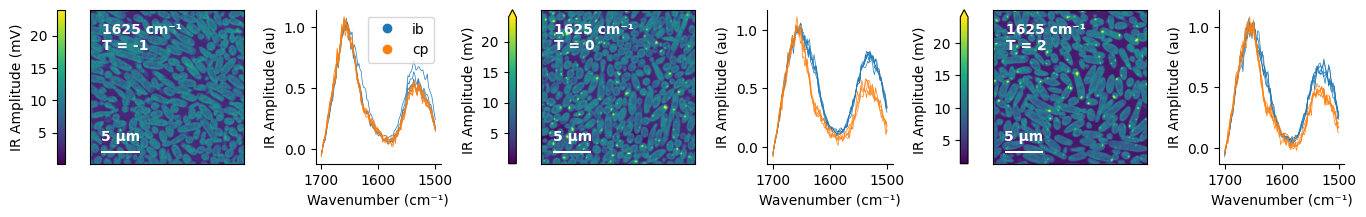

In [4]:
from matplotlib.lines import Line2D

def plot_examples(ax=None):
    if ax is None:
        fig, ax = plt.subplots(
            1, 6, figsize=(17, 2),
            gridspec_kw={'width_ratios': [1, .5, 1, .5, 1, .5]})
    
    plot_im = lambda dataset_id, ax, annot: aptwrapper.plot_map(
        images[dataset_id].amp1625,
        ax=ax,
        vmax=24,
        cmap='viridis', cb_label='IR Amplitude (mV)',
        annotation='1625 cm⁻¹\n'+annot, flatten=False)
    
    plot_im('recovery_timeline_july_BA', ax[0], 'T = -1')
    plot_im('recovery_timeline_july_HA', ax[2], 'T = 0')
    plot_im('recovery_timeline_july_R2A', ax[4], 'T = 2')

    def plot_spec(dataset_id, ax, plot_ib=True, legend=False):
        ss = spectra_processed['IR Amplitude (mV)']
        ss = ss[ss.dataset_id == dataset_id]
        ss = ss.sel(v=slice(1500, 1700))
        if plot_ib:
            ax.plot(ss.v, ss[ss.feature=='ib'].values.T, color='C0', lw=.5)
        ax.plot(ss.v, ss[ss.feature=='cp'].values.T, color='C1', lw=.5)
        ax.invert_xaxis()
        ax.set_xlabel('Wavenumber (cm⁻¹)')
        ax.set_ylabel('IR Amplitude (au)')
        if legend: ax.legend(handles=[
            Line2D([0], [0], color='C0', lw=0, marker='o', label='ib'),
            Line2D([0], [0], color='C1', lw=0, marker='o', label='cp'),
        ])
        sns.despine(ax=ax)

    plot_spec('recovery_timeline_july_BA', ax[1], legend=True)
    plot_spec('recovery_timeline_july_HA', ax[3])
    plot_spec('recovery_timeline_july_R2A', ax[5])


plot_examples()

# Second derivative spectra

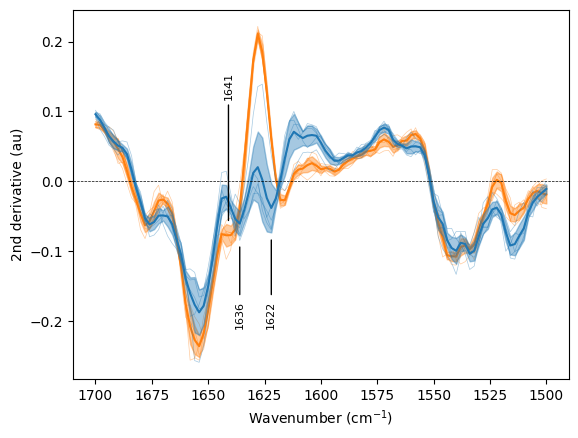

In [7]:
import numpy as np

def annotate_peak(ax, x, y, text=None, offset=-40, ha='center', va=None):
    if text is None: text=x
    if va is None and offset>0: va='baseline'
    if va is None and offset<0: va='top'
    # y = ymax if offset > 0 else ymin
    ax.annotate(
        text,
        [x,y],
        [x,
        y+offset],
        textcoords='data',
        rotation='vertical',
        va=va,
        ha=ha,
        arrowprops=dict(arrowstyle='-'),
        fontsize=8
    )

def plot_2diff(ax=None):
    if ax is None: ax = plt.gca()

    for i, f in enumerate(['ib', 'cp']):
        s2 = (
            spectra_processed['IR Amplitude (mV)']
            .sel(si=spectra_processed.feature==f)
            .groupby('condition').mean('si')
            .pipe(aptwrapper.savgol, 10, 2, 2)
            .pipe(lambda x: x / np.abs(x.sel(v=slice(1600, 1700)).sum('v')))
            .sel(v=slice(1500, 1700))
        )

        m = s2.mean('condition')
        se = 1.96 * s2.std('condition') / np.sqrt(s2.count('condition'))
        ax.plot(s2.v, m, c=f'C{i}', label=f, zorder=-10*i)
        ax.fill_between(s2.v, m+se, m-se, color=f'C{i}', alpha=.4, zorder=-10*i)

        for s in s2:
            ax.plot(s.v, s, c=f'C{i}', lw=.5, alpha=.4, zorder=-i)

    annotate_peak(ax, 1641, -.06, offset=.18)
    annotate_peak(ax, 1636, -.09, offset=-.08)
    annotate_peak(ax, 1622, -.08, offset=-.09)

    # ax.legend()
    ax.invert_xaxis()
    ax.axhline(0, c='k', lw=.5, ls='--')
    ax.set_ylabel('2nd derivative (au)')

    ax.set_xlabel('Wavenumber (cm$^{-1}$)')

fig, ax = plt.subplots()
plot_2diff(ax)

import os
output_directory = "../figures"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
fig.savefig('../figures/supp_recovery_2derivative', bbox_inches='tight')

# Spectrum data

## Spectrum beta content

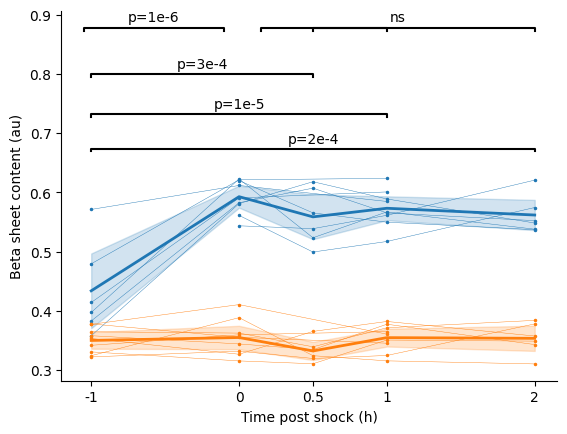

In [6]:
def plot_stats(data_source, data_column, feature=None, c='C0', ax=None):
    if ax is None: fig, ax = plt.subplots()
    if feature is not None: data_source = data_source.query('feature == @feature')

    for series in ['april', 'july', 'november']:
        for replicate in ['A', 'B', 'C']:

            df = (
                data_source
                .query('series == @series and replicate == @replicate')
                .groupby('time_post_shock')
                [data_column].mean()
            )
            ax.plot(
                df.index, df,
                c=c, lw=.3, marker='.', ms=3)
            
    df = (
        data_source
        .groupby(['series', 'replicate', 'time_post_shock'])
        [data_column].mean().reset_index()
        .groupby('time_post_shock')
        [data_column]
    )

    err = 1.96 * df.std() / df.count()**.5
    ax.plot(
        df.mean().index, 
        df.mean(),
        color=c, 
        lw=2,
    )

    ax.fill_between(
        df.mean().index, 
        df.mean() - err, 
        df.mean() + err, 
        color=c, 
        alpha=.2
    )
    
    ax.set_xticks([-1,0,.5,1,2])
    ax.set_xticklabels(['-1', '0', '0.5', '1', '2'])
    ax.set_xlabel('Time post shock (h)')

def plot_spectrum_beta2(ax=None):
    if ax is None: fig, ax = plt.subplots()

    plot_stats(spectrum_quantification, 'beta', feature='ib', c='C0', ax=ax)
    plot_stats(spectrum_quantification, 'beta', feature='cp', c='C1', ax=ax)
    ax.set_ylabel('Beta sheet content (au)')
    # utils.annot(ax, [1,.75], [1, .25], ['ns', ''])
    utils.annot(ax, .5, 1.5, 'p=2e-4')
    utils.annot(ax, 0, 1, 'p=1e-5')
    utils.annot(ax, -.25, .75, 'p=3e-4')
    utils.annot(ax, [-.575, 1.075, .75], [.475, 2-1.075, .25], ['p=1e-6', 'ns', ''])
    # ax.set_xlim(-1.2, 2.25)
    # utils.annotv(ax, .45, .1, '*')
    sns.despine(ax=ax)
    
plot_spectrum_beta2()

In [7]:
spectrum_quantification.query('time_post_shock>-1').groupby('feature').beta.mean()

feature
bg    0.557492
cp    0.345626
ib    0.569011
Name: beta, dtype: float64

Only IB before shock is significantly different from the rest.

In [8]:
utils.test_mean_differences(
    spectrum_quantification.query('feature != "bg"').assign(ft=
        lambda x: x.feature + '_' + x.time_post_shock.astype(str)),
    outcome='beta',
    groupby='ft',
    mean_over='dataset_id',
)

reject_H0                                                             True
using_anova                                                           True
p_anova                                                                0.0
p_kruskal                                                              0.0
p_shapiro                [4.749, 9.043, 7.977, 6.14, 8.692, 3.513, 3.45...
p_bartlett                                                        0.130706
n_per_group                                 [9, 9, 6, 9, 6, 6, 9, 6, 9, 6]
bonferroni_multiplier                                                   12
dtype: object

In [9]:
def tukey_hsd(data, outcome, groupby, mean_over):
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    from statsmodels.stats.multicomp import MultiComparison
    
    data = data.groupby([groupby, mean_over])[outcome].mean().reset_index()
    mc = MultiComparison(data[outcome], data[groupby])
    result = mc.tukeyhsd()
    return result

t = tukey_hsd(
    spectrum_quantification.query('feature == "ib"').assign(ft=
        lambda x: x.feature + '_' + x.time_post_shock.astype(str)),
    outcome='beta',
    groupby='ft',
    mean_over='dataset_id',
)
display(t.summary())
t.pvalues

group1,group2,meandiff,p-adj,lower,upper,reject
ib_-1.0,ib_0.0,0.1591,0.0,0.0912,0.227,True
ib_-1.0,ib_0.5,0.125,0.0003,0.0506,0.1994,True
ib_-1.0,ib_1.0,0.1395,0.0,0.0716,0.2075,True
ib_-1.0,ib_2.0,0.1281,0.0002,0.0537,0.2025,True
ib_0.0,ib_0.5,-0.0341,0.5992,-0.102,0.0338,False
ib_0.0,ib_1.0,-0.0196,0.8821,-0.0803,0.0412,False
ib_0.0,ib_2.0,-0.031,0.6805,-0.0989,0.0369,False
ib_0.5,ib_1.0,0.0145,0.9709,-0.0534,0.0825,False
ib_0.5,ib_2.0,0.0031,0.9999,-0.0713,0.0775,False
ib_1.0,ib_2.0,-0.0114,0.988,-0.0793,0.0565,False


array([1.30238720e-06, 2.88852749e-04, 1.34685557e-05, 2.05548172e-04,
       5.99204302e-01, 8.82067478e-01, 6.80534177e-01, 9.70883848e-01,
       9.99949076e-01, 9.88006863e-01])

In [10]:
print(2.99/7)
utils.test_mean_differences(
    spectrum_quantification.query('feature == "cp"'),
    outcome='beta',
    groupby='time_post_shock',
    mean_over='dataset_id',
)


0.42714285714285716


reject_H0                                            False
using_anova                                           True
p_anova                                            2.99102
p_kruskal                                         2.883561
p_shapiro                [2.77, 5.275, 4.653, 3.582, 5.07]
p_bartlett                                         5.64241
n_per_group                                [9, 9, 6, 9, 6]
bonferroni_multiplier                                    7
dtype: object

##  PLL

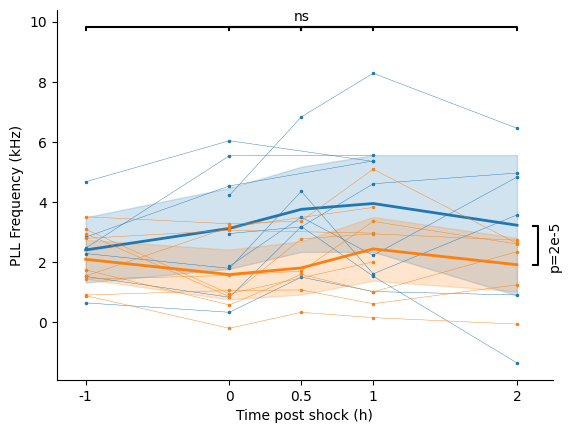

In [11]:
def plot_spectrum_pll(ax=None):
    if ax is None: fig, ax = plt.subplots()

    plot_stats(spectrum_quantification, 'pll', feature='ib', c='C0', ax=ax)
    plot_stats(spectrum_quantification, 'pll', feature='cp', c='C1', ax=ax)
    ax.set_ylabel('PLL Frequency (kHz)')
    utils.annot(ax, [.5,.5,.5], [0,.5,1.5], ['ns', '', ''])
    ax.set_xlim(-1.2, 2.25)
    utils.annotv(ax, 2.55, .65, 'p=2e-5')
    sns.despine(ax=ax)

plot_spectrum_pll()

In [12]:
print(5.029/7)
utils.test_mean_differences(
    spectrum_quantification.query('feature == "ib"'),
    outcome='pll',
    groupby='time_post_shock',
    mean_over='dataset_id',
)

0.7184285714285714


reject_H0                                              False
using_anova                                             True
p_anova                                             5.029177
p_kruskal                                           4.963585
p_shapiro                [5.664, 4.158, 3.406, 1.834, 3.824]
p_bartlett                                          3.697019
n_per_group                                  [6, 9, 6, 9, 6]
bonferroni_multiplier                                      7
dtype: object

In [13]:
print(4.8/7)
utils.test_mean_differences(
    spectrum_quantification.query('feature == "cp"'),
    outcome='pll',
    # groupby='feature',
    groupby='time_post_shock',
    mean_over='dataset_id',
)

0.6857142857142857


reject_H0                                              False
using_anova                                             True
p_anova                                             4.815152
p_kruskal                                           5.299893
p_shapiro                [1.683, 1.178, 6.193, 5.665, 0.311]
p_bartlett                                          4.964047
n_per_group                                  [9, 9, 6, 9, 6]
bonferroni_multiplier                                      7
dtype: object

In [14]:
utils.test_mean_differences(
    spectrum_quantification.query('feature != "bg"'),
    outcome='pll',
    groupby=['feature', 'time_post_shock',],
    mean_over='dataset_id',
)

reject_H0                                                            False
using_anova                                                           True
p_anova                                                           1.311674
p_kruskal                                                         2.394918
p_shapiro                [2.884, 2.019, 10.617, 9.711, 0.534, 9.71, 7.1...
p_bartlett                                                         1.28462
n_per_group                                 [9, 9, 6, 9, 6, 6, 9, 6, 9, 6]
bonferroni_multiplier                                                   12
dtype: object

In [15]:
import scipy.stats

df = (
    spectrum_quantification
    .query('feature!="bg"')
    .groupby(['feature', 'dataset_id', 'time_post_shock'])
    .pll.mean()
    .unstack('feature')
    .dropna()
)

print(scipy.stats.shapiro(df.ib))
print(scipy.stats.shapiro(df.cp))
print(scipy.stats.bartlett(df.ib, df.cp))
print(scipy.stats.wilcoxon(df.ib, df.cp))
print(scipy.stats.wilcoxon(df.ib, df.cp).pvalue*4)

ShapiroResult(statistic=0.9840606259787306, pvalue=0.8717342592154302)
ShapiroResult(statistic=0.9623451228060957, pvalue=0.25367441876185787)
BartlettResult(statistic=9.685891531870178, pvalue=0.0018568826804256364)
WilcoxonResult(statistic=63.0, pvalue=3.958528395742178e-06)
1.5834113582968712e-05


# Map data

## IB Area


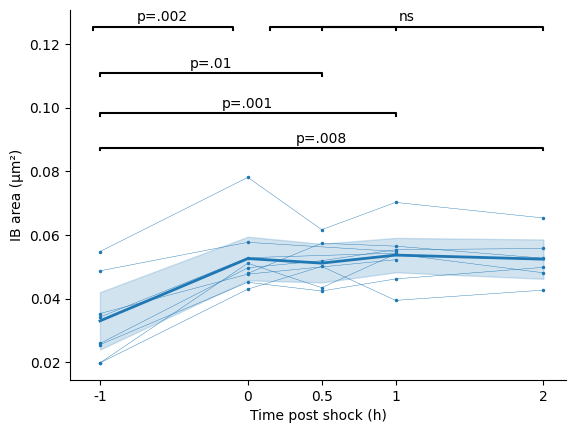

In [16]:
def plot_map_ib_area(ax=None):
    if ax is None: fig, ax = plt.subplots()

    plot_stats(ibtable, 'ib_area', c='C0', ax=ax)
    ax.set_ylabel('IB area (µm²)')
    utils.annot(ax, .5, 1.5, 'p=.008')
    utils.annot(ax, 0, 1, 'p=.001')
    utils.annot(ax, -.25, .75, 'p=.01')
    utils.annot(ax, [-.575, 1.075, .75], [.475, 2-1.075, .25], ['p=.002', 'ns', ''])
    sns.despine(ax=ax)
    
plot_map_ib_area()

In [17]:
utils.test_mean_differences(
    ibtable,
    outcome='ib_area',
    groupby='time_post_shock',
    mean_over='dataset_id',
)

reject_H0                                               True
using_anova                                             True
p_anova                                             0.004851
p_kruskal                                           0.180792
p_shapiro                [1.727, 0.067, 4.825, 1.664, 6.023]
p_bartlett                                          4.233932
n_per_group                                  [8, 9, 6, 9, 6]
bonferroni_multiplier                                      7
dtype: object

In [18]:
tukey_hsd(
    ibtable,
    outcome='ib_area',
    groupby='time_post_shock',
    mean_over='dataset_id',
).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
-1.0,0.0,0.0196,0.0023,0.0058,0.0334,True
-1.0,0.5,0.0181,0.0138,0.0028,0.0335,True
-1.0,1.0,0.0207,0.0012,0.0069,0.0344,True
-1.0,2.0,0.0194,0.0075,0.0041,0.0347,True
0.0,0.5,-0.0014,0.9987,-0.0164,0.0135,False
0.0,1.0,0.0011,0.9993,-0.0123,0.0145,False
0.0,2.0,-0.0002,1.0,-0.0151,0.0148,False
0.5,1.0,0.0025,0.9882,-0.0124,0.0175,False
0.5,2.0,0.0012,0.9995,-0.0151,0.0176,False
1.0,2.0,-0.0013,0.9992,-0.0162,0.0137,False


## IB Load

Text(0, 0.5, 'IB load (measure of total area)')

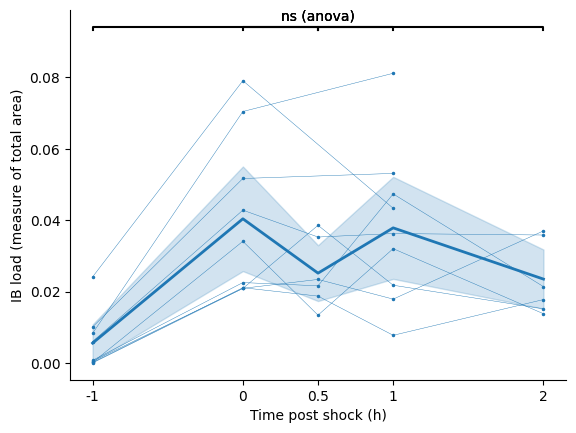

In [19]:
plot_stats(celltable, 'cell_frac_ib')
utils.annot(plt.gca(), [.5,.5,.5], [0,.5,1.5], 'ns (anova)')
sns.despine()
plt.ylabel('IB load (measure of total area)')

In [20]:
utils.test_mean_differences(
    ibtable,
    outcome='cell_frac_ib',
    groupby='time_post_shock',
    mean_over='dataset_id',
)

reject_H0                                              False
using_anova                                             True
p_anova                                             1.107658
p_kruskal                                           2.237148
p_shapiro                [2.905, 0.793, 0.667, 5.205, 4.371]
p_bartlett                                          0.432973
n_per_group                                  [8, 9, 6, 9, 6]
bonferroni_multiplier                                      7
dtype: object

## Num IBs

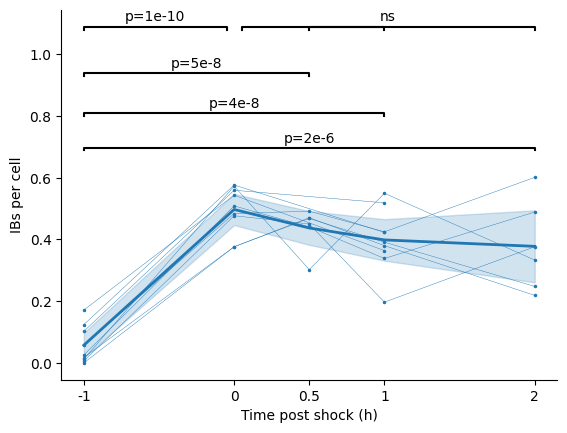

In [21]:
def plot_map_ib_num(ax=None):
    if ax is None: fig, ax = plt.subplots()

    # plot_stats(ibtable, 'ib_num', c='C0', ax=ax)
    plot_stats(celltable, 'cell_num_ibs', ax=ax, c='C0')
    ax.set_ylabel('IBs per cell')

    # utils.annot(ax, -.5, .5, 'p=1e-10')
    utils.annot(ax, .5, 1.5, 'p=2e-6')
    utils.annot(ax, 0, 1, 'p=4e-8')
    utils.annot(ax, -.25, .75, 'p=5e-8')
    utils.annot(ax, [-.525, 1.025,.75], [.475, .975, .25], ['p=1e-10', 'ns', ''])
    sns.despine(ax=ax)

plot_map_ib_num()

In [22]:
utils.test_mean_differences(
    celltable,
    outcome='cell_num_ibs',
    groupby='time_post_shock',
    mean_over='dataset_id',
)

reject_H0                                               True
using_anova                                             True
p_anova                                                  0.0
p_kruskal                                           0.000679
p_shapiro                [0.697, 0.745, 0.116, 4.336, 4.987]
p_bartlett                                          1.391206
n_per_group                                  [9, 9, 6, 9, 6]
bonferroni_multiplier                                      7
dtype: object

In [23]:
r = tukey_hsd(
    celltable,
    outcome='cell_num_ibs',
    groupby='time_post_shock',
    mean_over='dataset_id',
)

display(r.summary())

r.pvalues

group1,group2,meandiff,p-adj,lower,upper,reject
-1.0,0.0,0.4397,0.0,0.3139,0.5656,True
-1.0,0.5,0.3798,0.0,0.2391,0.5205,True
-1.0,1.0,0.3411,0.0,0.2152,0.4669,True
-1.0,2.0,0.3203,0.0,0.1796,0.461,True
0.0,0.5,-0.0599,0.7363,-0.2006,0.0808,False
0.0,1.0,-0.0987,0.1838,-0.2245,0.0272,False
0.0,2.0,-0.1194,0.1281,-0.2602,0.0213,False
0.5,1.0,-0.0387,0.931,-0.1794,0.102,False
0.5,2.0,-0.0595,0.7991,-0.2137,0.0946,False
1.0,2.0,-0.0208,0.9928,-0.1615,0.1199,False


array([9.82131043e-11, 4.69507584e-08, 4.29721919e-08, 1.59194428e-06,
       7.36289508e-01, 1.83827232e-01, 1.28066775e-01, 9.30985676e-01,
       7.99139644e-01, 9.92844489e-01])

## IB Beta rato

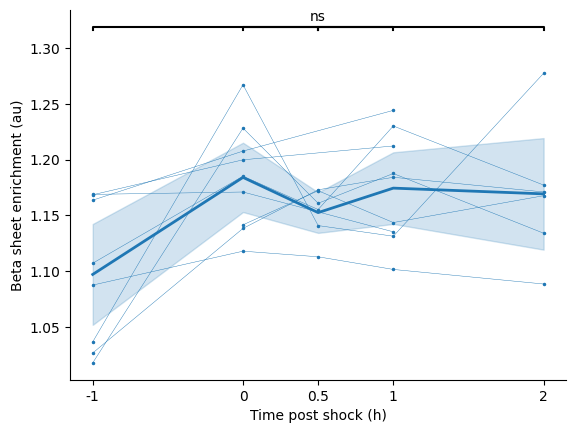

In [24]:
def plot_map_ratio(ax=None):
    if ax is None: fig, ax = plt.subplots()

    plot_stats(ibtable, 'beta_ratio_fc', c='C0', ax=ax)
    ax.set_ylabel('Beta sheet enrichment (au)')
    # ax.axhline(1, c='k', lw=.5, ls='--')
    # ax.set_xlim(-1.2, 2.25)
    # utils.annotv(ax, 1.08, .08, 'p=2e-18')
    utils.annot(ax, [.5, .5, .5], [0, .5, 1.5], ['ns', '', ''])
    sns.despine(ax=ax)
    
plot_map_ratio()

In [25]:
utils.test_mean_differences(
    ibtable,
    outcome='beta_ratio_fc',
    groupby='time_post_shock',
    mean_over='dataset_id',
)

reject_H0                                            False
using_anova                                           True
p_anova                                           0.105676
p_kruskal                                         0.416715
p_shapiro                [0.76, 6.52, 2.118, 4.785, 3.427]
p_bartlett                                        1.814312
n_per_group                                [8, 9, 6, 9, 6]
bonferroni_multiplier                                    7
dtype: object

In [26]:
df = (
    ibtable.groupby('dataset_id').beta_ratio_fc.mean()
)

print('mean:', df.mean())
print('alpha:', .05/2)
print(scipy.stats.shapiro(df))
t = scipy.stats.ttest_1samp(df, 1)
print(t)
print(t.confidence_interval(.975))

mean: 1.1561544378962572
alpha: 0.025
ShapiroResult(statistic=0.9693211040543573, pvalue=0.3737609294784785)
TtestResult(statistic=16.339806469057145, pvalue=1.6611577991283404e-18, df=37)
ConfidenceInterval(low=1.1338269940592476, high=1.178481881733267)


## PLL

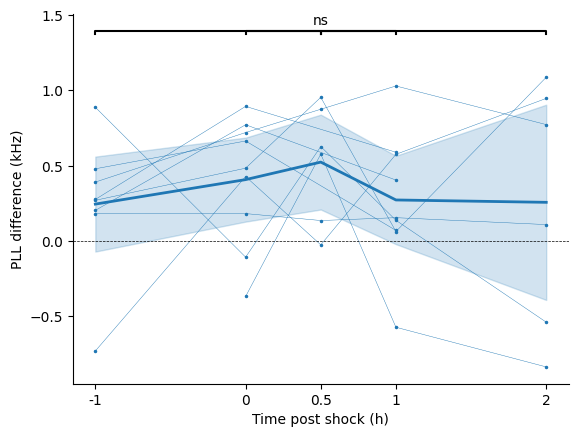

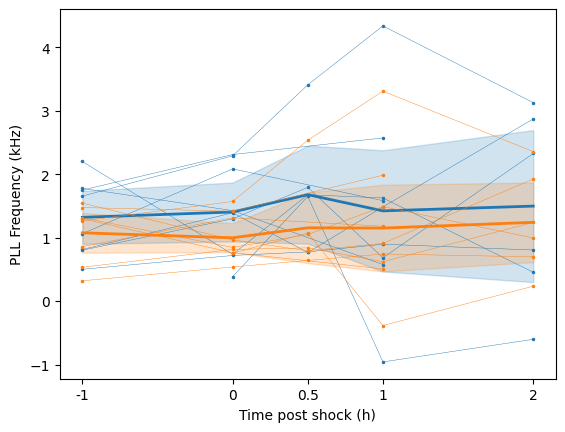

In [27]:
def plot_map_pll_diff(ax=None):
    if ax is None: fig, ax = plt.subplots()

    plot_stats(ibtable, 'ib_pll_diff', c='C0', ax=ax)
    utils.annot(ax, [.5,.5,.5], [0,.5,1.5], ['ns', '', ''])
    ax.set_ylabel('PLL difference (kHz)')
    ax.axhline(0, c='k', lw=.5, ls='--')
    sns.despine(ax=ax)

def plot_map_pll_mean(ax=None):
    if ax is None: fig, ax = plt.subplots()

    plot_stats(ibtable, 'ib_pll_mean', c='C0', ax=ax)
    plot_stats(ibtable, 'cp_pll_mean', c='C1', ax=ax)
    ax.set_ylabel('PLL Frequency (kHz)')
    
plot_map_pll_diff()
plot_map_pll_mean()

No differences between timepoints

In [28]:
print(5.7/7)
print(utils.test_mean_differences(
    ibtable,
    outcome='ib_pll_diff',
    groupby='time_post_shock',
    mean_over='dataset_id',
))
print(utils.test_mean_differences(
    ibtable,
    outcome='ib_pll_mean',
    groupby='time_post_shock',
    mean_over='dataset_id',
))
print(utils.test_mean_differences(
    ibtable,
    outcome='cp_pll_mean',
    groupby='time_post_shock',
    mean_over='dataset_id',
))

0.8142857142857143
reject_H0                                              False
using_anova                                             True
p_anova                                             5.733803
p_kruskal                                           5.805152
p_shapiro                [0.597, 2.701, 3.304, 4.966, 2.356]
p_bartlett                                          2.698237
n_per_group                                  [8, 9, 6, 9, 6]
bonferroni_multiplier                                      7
dtype: object
reject_H0                                           False
using_anova                                          True
p_anova                                          6.868574
p_kruskal                                        6.707316
p_shapiro                [3.33, 2.519, 1.06, 4.35, 3.539]
p_bartlett                                       0.578193
n_per_group                               [8, 9, 6, 9, 6]
bonferroni_multiplier                                   7
dtype: object
r

ib_pll_mean and cp_pll_mean are signifiantly different from 0 and from each other

In [29]:
import scipy.stats

df = (
    ibtable
    .groupby(['dataset_id'])
    [['ib_pll_diff', 'ib_pll_mean', 'cp_pll_mean']]
    .mean(numeric_only=True)
    # .dropna()
)

print('alpha:', .05/6)
print(scipy.stats.shapiro(df.ib_pll_mean))
print(scipy.stats.shapiro(df.cp_pll_mean))
print(scipy.stats.bartlett(df.ib_pll_mean, df.cp_pll_mean))

t = scipy.stats.ttest_rel(df.ib_pll_mean, df.cp_pll_mean)
print(t.pvalue*3)

alpha: 0.008333333333333333
ShapiroResult(statistic=0.9680345337913316, pvalue=0.3416024859069809)
ShapiroResult(statistic=0.9290847268409695, pvalue=0.018773003434055833)
BartlettResult(statistic=6.569382835516717, pvalue=0.010374792147409193)
0.0004950086774214102


In [30]:
df = ibtable.groupby('dataset_id').ib_pll_diff.mean()
print('mean:', df.mean())
print('alpha:', .05/2)
print(scipy.stats.shapiro(df))
t = scipy.stats.ttest_1samp(df, 0)
# t = scipy.stats
print(t)
print(t.pvalue*2)

mean: 0.33507850112180726
alpha: 0.025
ShapiroResult(statistic=0.9485849164278093, pvalue=0.07998351788841998)
TtestResult(statistic=4.19210286357852, pvalue=0.00016500289247380385, df=37)
0.0003300057849476077


# Composite

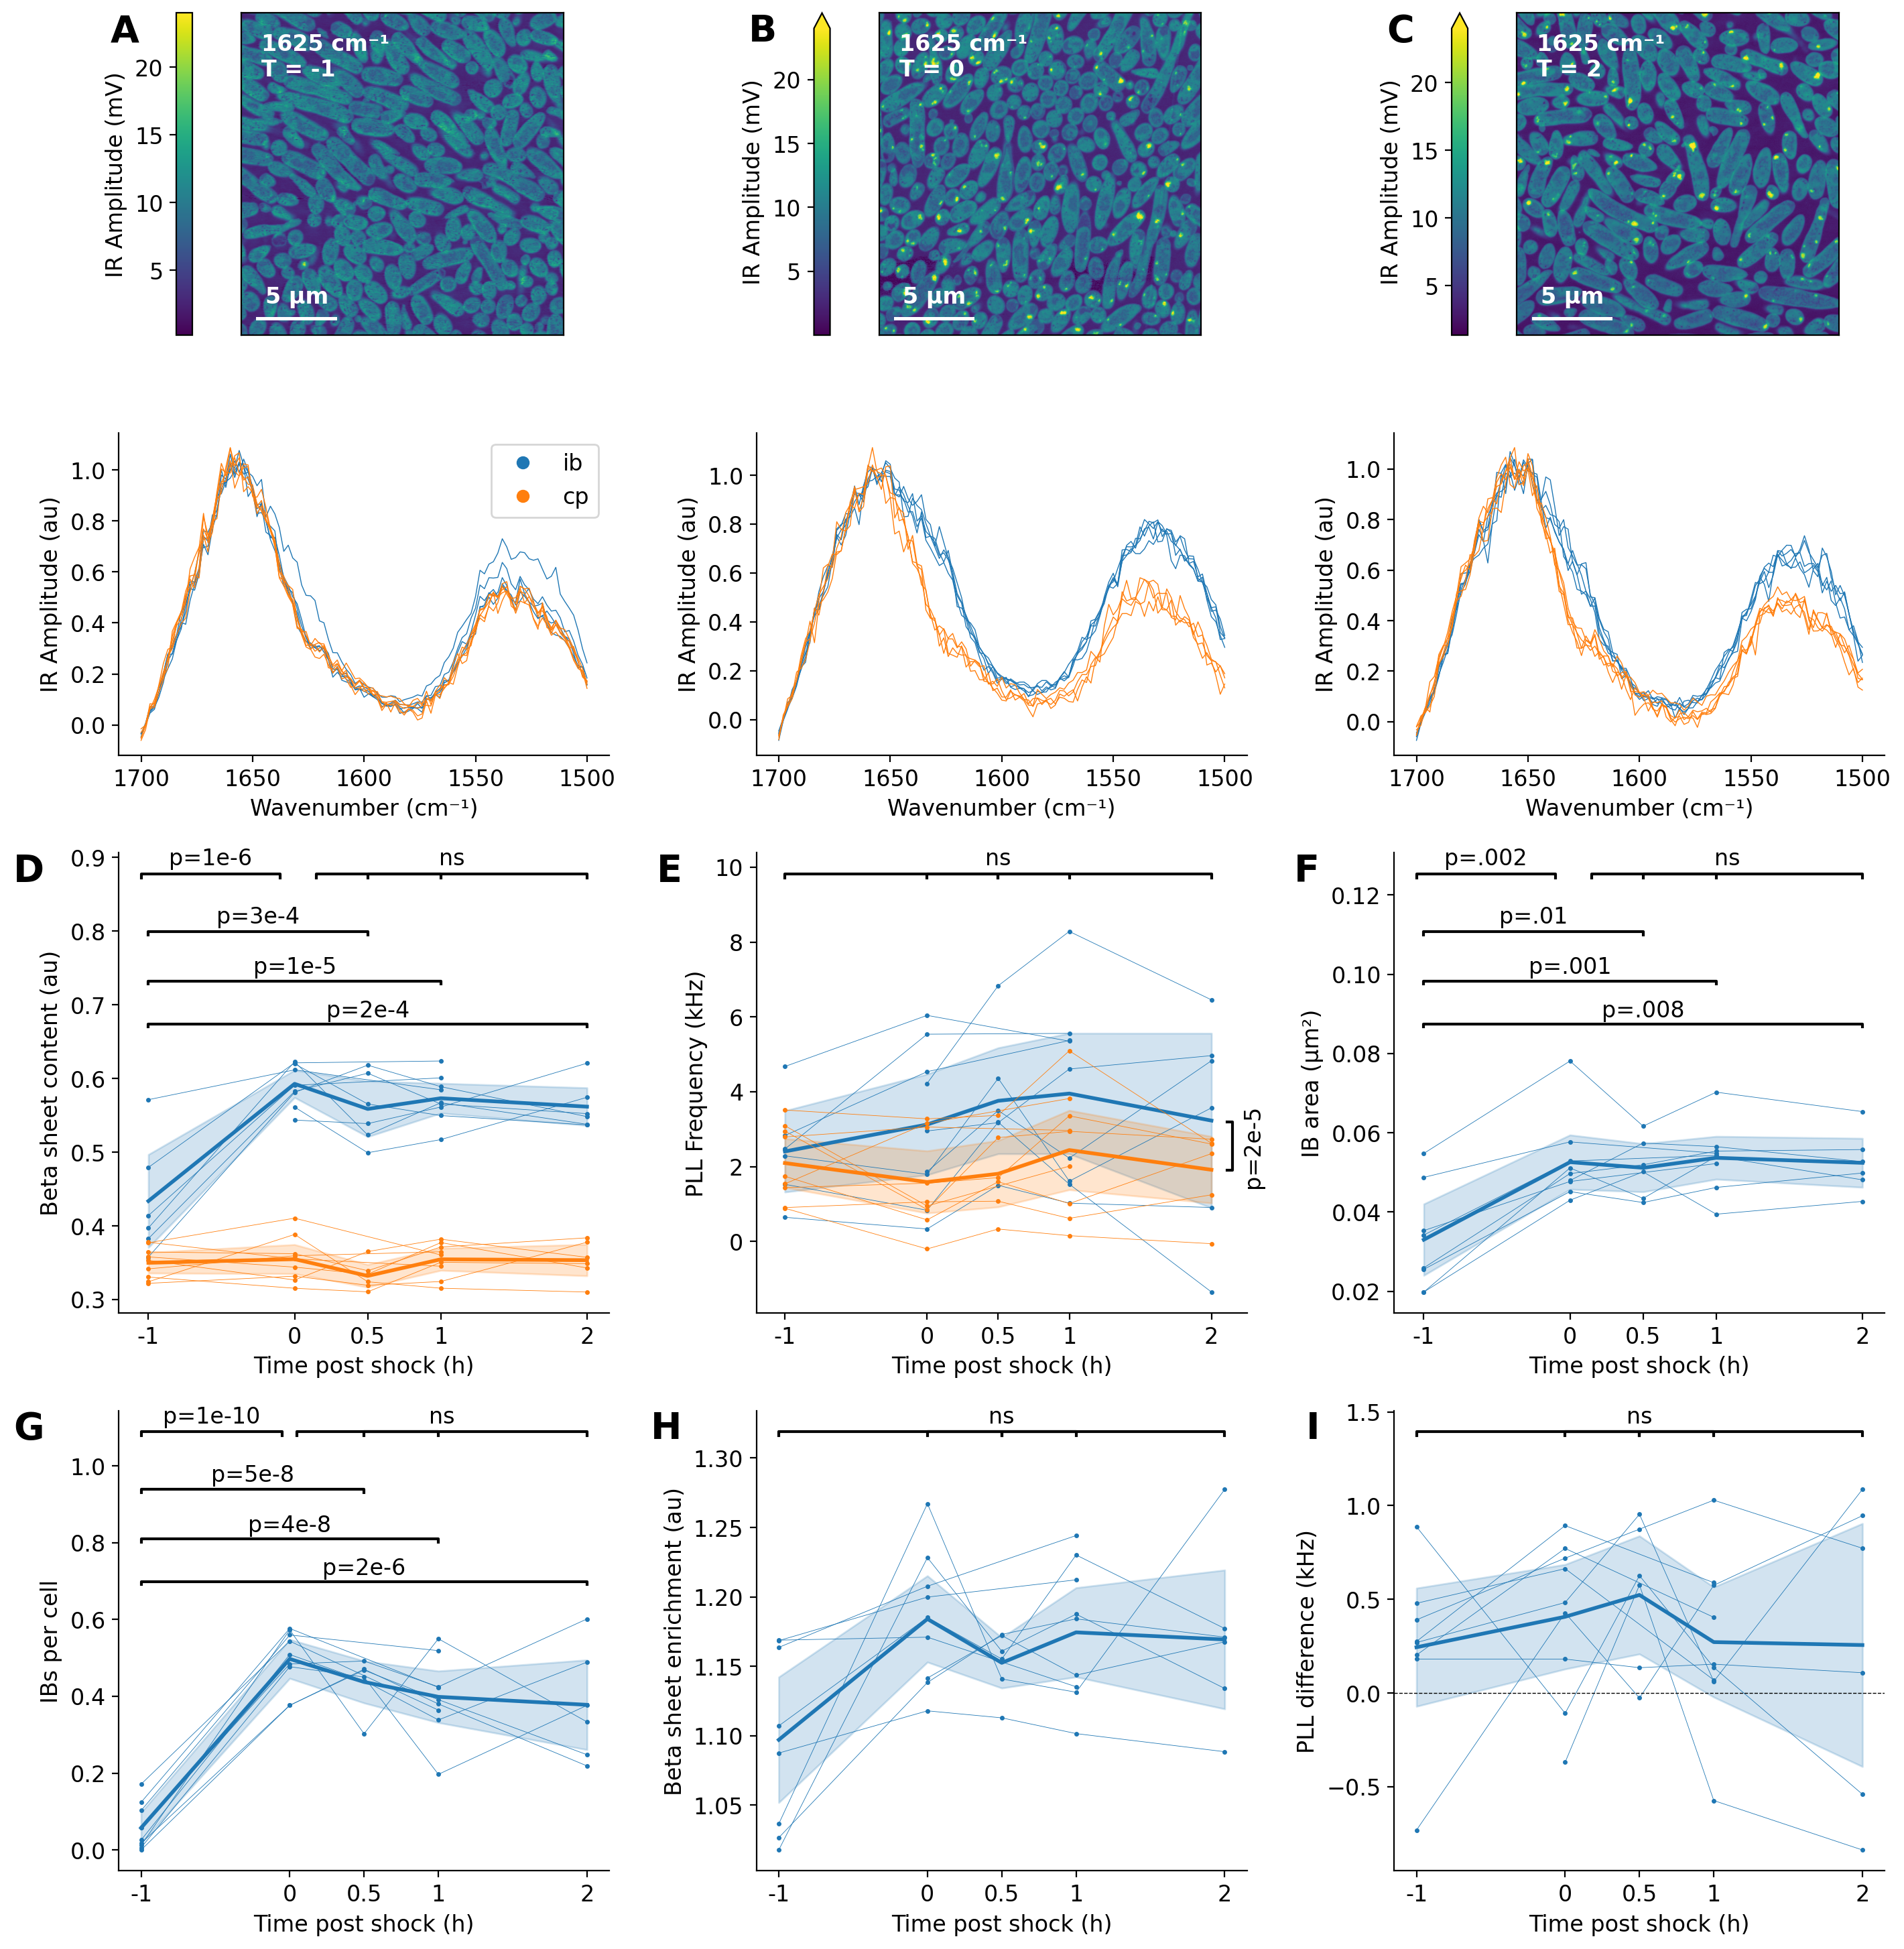

In [33]:
with plt.rc_context({
    'figure.figsize': (17,18),
    'figure.dpi': 200,
    'font.size': 12,
    'savefig.bbox': 'tight',
    'legend.loc': 'upper right',
}):

    fig, ax = plt.subplot_mosaic(
        gridspec_kw={'wspace': .3, 'hspace':.25, 'height_ratios': [.7,.7,1,1]},
        mosaic=[
            ['a', 'b', 'c'],
            ['d', 'e', 'f'],
            ['g', 'h', 'i'],
            ['j', 'k', 'l'],
    ])
    plot_examples(ax=[ax['a'], ax['d'], ax['b'], ax['e'], ax['c'], ax['f']])
    plot_spectrum_beta2(ax=ax['g'])
    plot_spectrum_pll(ax=ax['h'])
    plot_map_ib_area(ax=ax['i'])
    plot_map_ib_num(ax=ax['j'])
    plot_map_ratio(ax=ax['k'])
    plot_map_pll_diff(ax=ax['l'])

    kwargs = dict(ha='right', va='top', xycoords=('axes points', 'axes fraction'), fontsize=20, fontweight='bold')
    xy = (-40, 1)
    ax['a'].annotate('A', (-55,1), **kwargs)
    ax['b'].annotate('B', (-55,1), **kwargs)
    ax['c'].annotate('C', (-55,1), **kwargs)
    ax['g'].annotate('D', xy, **kwargs)
    ax['h'].annotate('E', xy, **kwargs)
    ax['i'].annotate('F', xy, **kwargs)
    ax['j'].annotate('G', xy, **kwargs)
    ax['k'].annotate('H', xy, **kwargs)
    ax['l'].annotate('I', xy, **kwargs)

    import os
    output_directory = "../figures"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    fig.savefig('../figures/figure_5.pdf', bbox_inches='tight')